In [1]:
import glob
import random
import os
import csv
import numpy as np
from tqdm import tqdm
import matplotlib
from plotly.offline import iplot, init_notebook_mode
import plotly.io as pio
from numpy import linalg as LAnumpy
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.legend_handler import HandlerLine2D

# Constants

In [2]:
NB_NODES = 202
EMBEDDING_SIZE = 3 # Euclidean 3D space
CELL_STRUCTURES_PATH = 'data/trussart/trussart_structure_original/'
NB_TRUSSART_TEST_STRUCTURES = 100

# Create dataset

### Structure matrices

In [3]:
test_transfer_learning_structures = []

file_list = os.listdir(CELL_STRUCTURES_PATH)
file_list = filter(lambda f: f.endswith('.xyz'), file_list)

for file_name in file_list:
    current_test_transfer_learning_structure = np.loadtxt(CELL_STRUCTURES_PATH + file_name, dtype='f', delimiter='\t')
    current_test_transfer_learning_structure = current_test_transfer_learning_structure[:,1:]
    test_transfer_learning_structures.append(current_test_transfer_learning_structure)

# Procruste analysis functions

### Torch

In [4]:
def centralize_torch(z):
    return z - torch.repeat_interleave(torch.reshape(torch.mean(z, axis=1), (-1,1,EMBEDDING_SIZE)), NB_NODES, dim=1)

In [5]:
def normalize_torch(z):
    
    norms = LAtorch.norm(z, 2, dim=2)
    max_norms, _ = torch.max(norms, axis=1)
    max_norms = torch.reshape(max_norms, (BATCH_SIZE,1,1))
    max_norms = torch.repeat_interleave(max_norms, NB_NODES, dim=1)
    max_norms = torch.repeat_interleave(max_norms, EMBEDDING_SIZE, dim=2)
    max_norms[max_norms == 0] = 1
    
    return z / max_norms

In [6]:
def centralize_and_normalize_torch(z):
    
    # Translate
    z = centralize_torch(z)
    
    # Scale
    z = normalize_torch(z)
    
    return z

In [7]:
def structure_loss_fct(pred_structure, true_structure):
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = torch.matmul(true_structure, torch.transpose(pred_structure, 1, 2))    
    u, s, vh = torch.svd_lowrank(m, q=EMBEDDING_SIZE)
    r = torch.matmul(u, torch.transpose(vh, 1, 2))

    pred_structure = torch.matmul(r, pred_structure)
    
    return torch.mean(torch.sum(torch.square(pred_structure - true_structure), axis=2))

### Numpy

In [8]:
def centralize_numpy(z):
    return z - np.mean(z, axis=0)

In [9]:
def normalize_numpy(z):
    
    norm = LAnumpy.norm(z, 2, axis=1)
    max_norm = np.max(norm, axis=0)
    if max_norm == 0:
        max_norm = 1
    
    return z / max_norm

In [10]:
def centralize_and_normalize_numpy(z):
    
    # Translate
    z = centralize_numpy(z)
    
    # Scale
    z = normalize_numpy(z)
    
    return z

In [11]:
def procrustes_superimposition_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(true_structure_unit_ball, np.transpose(pred_structure_unit_ball))
    u, s, vh = np.linalg.svd(m, full_matrices=False)
    r = np.matmul(u, vh)
    pred_structure_unit_ball = np.matmul(r, pred_structure_unit_ball)
    
    return pred_structure_unit_ball, true_structure_unit_ball

In [12]:
def procrustes_distance_numpy(pred_structure, true_structure):
    
    # Centralize and normalize to unit ball
    pred_structure_unit_ball = centralize_and_normalize_numpy(pred_structure)
    true_structure_unit_ball = centralize_and_normalize_numpy(true_structure)
    
    # Rotation (solution for the constrained orthogonal Procrustes problem, subject to det(R) = 1)
    m = np.matmul(true_structure_unit_ball, np.transpose(pred_structure_unit_ball))
    u, s, vh = np.linalg.svd(m, full_matrices=False)
    r = np.matmul(u, vh)
    pred_structure_unit_ball = np.matmul(r, pred_structure_unit_ball)
    
    # Structure comparison
    d = np.mean(np.sum(np.square(pred_structure_unit_ball - true_structure_unit_ball), axis=1))
    
    return d

# Structure visualization

In [14]:
tsv_file = open('data/trussart/trussart_structure_generated/trussart_hic_formatted_structure.tsv')
read_tsv = csv.reader(tsv_file, delimiter='\t')

structure = []
for row in read_tsv:       
    structure.append(row)

structure = structure[3:]
pred_structure = np.asarray(structure).astype('float')
pred_structure = pred_structure[:,1:]

In [37]:
np.savetxt('minimds_trussart_output_structure.txt', pred_structure, delimiter='\t')

#### Best structure visalization

In [15]:
pred_structure.shape

(202, 3)

In [16]:
test_structure_losses_synthetic  = []

for true_structure in test_transfer_learning_structures:  
    d = procrustes_distance_numpy(pred_structure, true_structure)
    test_structure_losses_synthetic.append(d)

In [17]:
BEST_STRUCTURE_INDEX = 0

In [18]:
closest_structures_indices = np.argsort(test_structure_losses_synthetic)

In [19]:
graph_tested_synthetic = closest_structures_indices[BEST_STRUCTURE_INDEX]

In [20]:
true_structure_synthetic = test_transfer_learning_structures[graph_tested_synthetic]

pred_structure_synthetic_pro, true_structure_synthetic_pro = \
            procrustes_superimposition_numpy(pred_structure, true_structure_synthetic)

# Shape comparison
d = np.mean(np.sum(np.square(pred_structure_synthetic_pro - true_structure_synthetic_pro), axis=1))
print('Procrustes distance is ' + str(d))

Procrustes distance is 0.009453334623789939


In [21]:
x_pred = pred_structure_synthetic_pro[:, 0]  
y_pred = pred_structure_synthetic_pro[:, 1]
z_pred = pred_structure_synthetic_pro[:, 2]

x_true = true_structure_synthetic_pro[:, 0]  
y_true = true_structure_synthetic_pro[:, 1]
z_true = true_structure_synthetic_pro[:, 2]

In [22]:
# Initialize figure with 4 3D subplots
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# adding surfaces to subplots.
fig.add_trace(
    go.Scatter3d(
    x=x_true, y=y_true, z=z_true,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_true))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
),row=1, col=1)

fig.add_trace(
    go.Scatter3d(
    x=x_pred, y=y_pred, z=z_pred,
    marker=dict(
        size=4,
        color=np.asarray(range(len(x_pred))),
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
), row=1, col=2)

fig.update_layout(
    title_text='3D subplots with different colorscales',
    height=1000,
    width=1000
)

fig.show()

#### All structures visualization

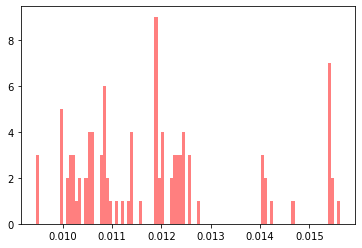

best latent:0.009453334623789939
mean latent: 0.011858004874199237
median latent: 0.01187511128818686
variance latent: 2.690515942391883e-06


In [25]:
n, bins, patches = plt.hist(test_structure_losses_synthetic, NB_TRUSSART_TEST_STRUCTURES, facecolor='red', 
                            alpha=0.5)
    
plt.show()

print('best latent:' + str(np.min(test_structure_losses_synthetic)))
print('mean latent: ' + str(np.mean(test_structure_losses_synthetic)))
print('median latent: ' + str(np.median(test_structure_losses_synthetic)))
print('variance latent: ' + str(np.var(test_structure_losses_synthetic)))

In [33]:
stacked_structures = []

for structure in test_transfer_learning_structures:
    stacked_structures.append(centralize_and_normalize_numpy(structure))

stacked_structures = np.asarray(stacked_structures)

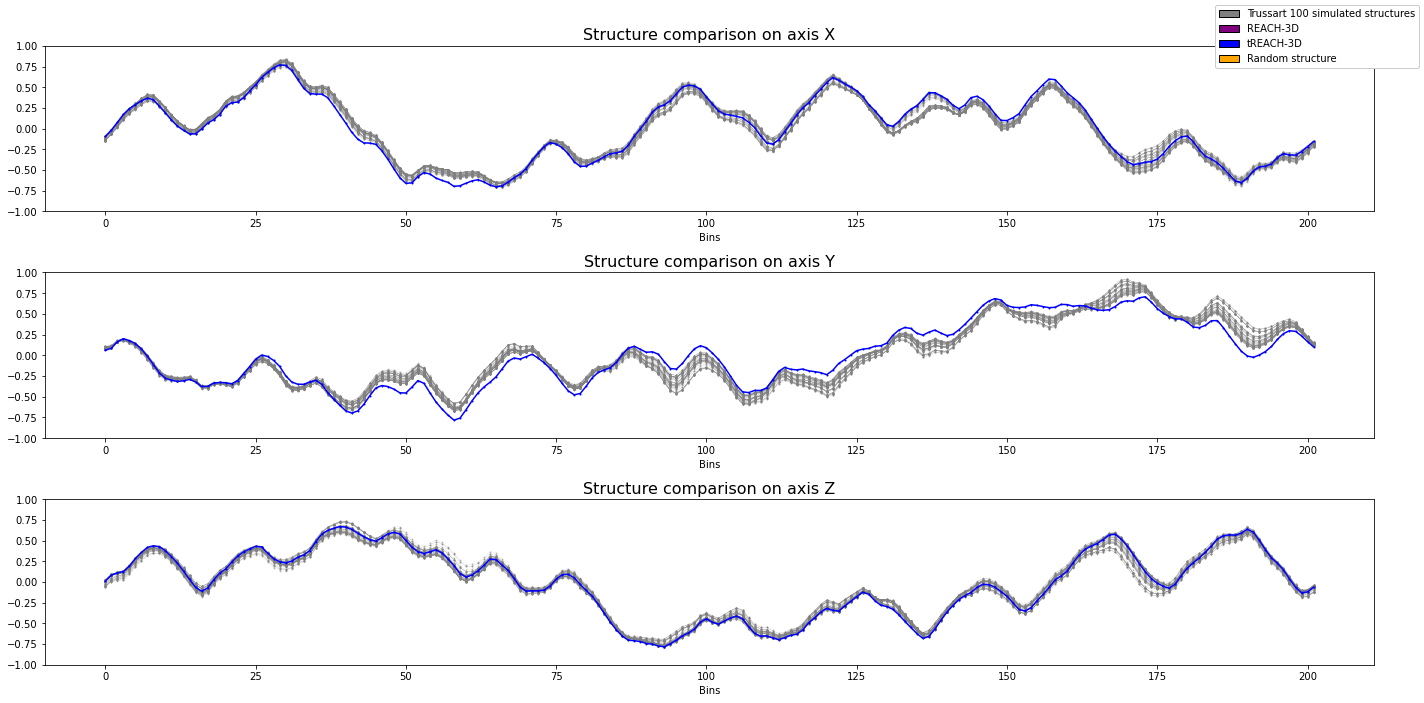

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(20,10))
fig.tight_layout(pad=4.0)
axis_names = ['X','Y','Z']

for i in range(EMBEDDING_SIZE):

    # Trussart
    for j in range(NB_TRUSSART_TEST_STRUCTURES):
        axes[i].plot(range(NB_NODES), stacked_structures[j,:,i], color='gray', 
                  marker='o', linestyle='solid', linewidth=0.2, markersize=1, alpha=0.4)

    # miniMDS
    axes[i].plot(range(NB_NODES), pred_structure_synthetic_pro[:,i], color='blue', 
                  marker='o', linestyle='solid', linewidth=1.5, markersize=1, alpha=1)
    
    axes[i].set_title('Structure comparison on axis ' + axis_names[i], fontsize=16)
    axes[i].set_xlabel('Bins', fontsize=10)
    axes[i].set_ylim(-1,1)

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in ['gray', 'purple', 'blue', 'orange']]
labels= ['Trussart 100 simulated structures', 'REACH-3D', 'tREACH-3D', 'Random structure']
fig.legend(handles, labels, framealpha=1)
   
plt.show()